In [1]:
import sys
sys.path.append("..")
import models
import policy_gradient_methods
import utils
import gymnasium as gym
import torch
import random

# Settings

In [2]:
ENVIRONMENT_ID = "CartPole-v1"
NUM_RUNS_PER_METHOD = 9
NUM_EPISODES_PER_RUN = 100
GRAD_CLIP_VALUE = 10
GAMMA = 0.99
NN_HIDDEN_LAYER_SIZES = [8, 4]
RNG_SEED = 7
device = torch.device("cpu")
print("PyTorch device:", device)
torch.manual_seed(RNG_SEED)
random.seed(RNG_SEED)

PyTorch device: cpu


# One-step Actor-Critic

## Linear models

In [3]:
def train_episodic_one_step_actor_critic(
        env, policy_model, value_model, policy_optimizer, value_optimizer, device, rng_seed, num_episodes, gamma, grad_clip_value=None):
    returns = []
    for episode in range(num_episodes):
        # Set seed only one time per training run. For more info, see https://gymnasium.farama.org/api/env/.
        observation, info = env.reset(seed=rng_seed if episode == 0 else None)
        state = torch.tensor(observation, device=device)
        truncated = False
        terminated = False
        I = 1
        G = 0
        while not (terminated or truncated):
            with torch.no_grad():
                action_probabilities = policy_model(state)
            action = policy_gradient_methods.select_action(action_probabilities)
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = torch.tensor(observation, device=device)
            with torch.no_grad():
                state_value = value_model(state)
                next_state_value = 0 if terminated else value_model(next_state)
            delta = reward + gamma * next_state_value - state_value
            value_loss = -torch.sum(delta * value_model(state))
            policy_gradient_methods.update_model(value_loss, value_optimizer, value_model, grad_clip_value)
            policy_loss = -torch.sum(I * delta * torch.log(policy_model(state)[action]))
            policy_gradient_methods.update_model(policy_loss, policy_optimizer, policy_model, grad_clip_value)
            I *= gamma
            state = next_state
            G += reward
        returns.append(G)
    return returns

Started run 1/9
Started run 2/9
Started run 3/9
Started run 4/9
Started run 5/9
Started run 6/9
Started run 7/9
Started run 8/9
Started run 9/9


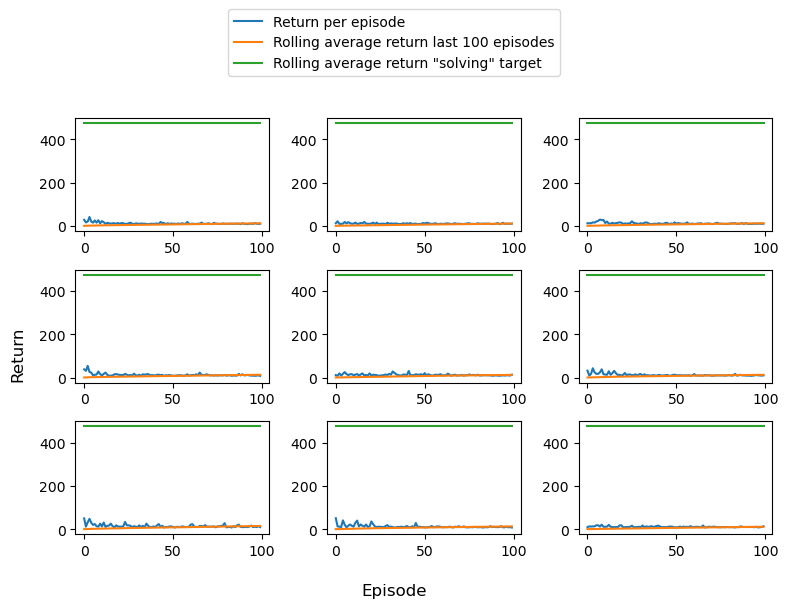

In [4]:
returns_per_run = []
env = gym.make(ENVIRONMENT_ID)
for run in range(NUM_RUNS_PER_METHOD):
    print(f"Started run {run + 1}/{NUM_RUNS_PER_METHOD}")
    policy_model = torch.nn.Sequential(
        torch.nn.Linear(env.observation_space.shape[0], env.action_space.n),
        torch.nn.Softmax(dim=0)
    ).to(device)
    value_model = torch.nn.Linear(env.observation_space.shape[0], 1).to(device)
    policy_optimizer = torch.optim.SGD(policy_model.parameters(), lr=0.01)
    value_optimizer = torch.optim.SGD(value_model.parameters(), lr=0.01)
    returns = train_episodic_one_step_actor_critic(
        env, policy_model, value_model, policy_optimizer, value_optimizer, device,
        RNG_SEED, NUM_EPISODES_PER_RUN, GAMMA, GRAD_CLIP_VALUE
    )
    returns_per_run.append(returns)
env.close()
utils.plot_returns_multiple_runs(returns_per_run, env.spec.reward_threshold)

## Neural network models

Started run 1/9
Started run 2/9
Started run 3/9
Started run 4/9
Started run 5/9
Started run 6/9
Started run 7/9
Started run 8/9
Started run 9/9


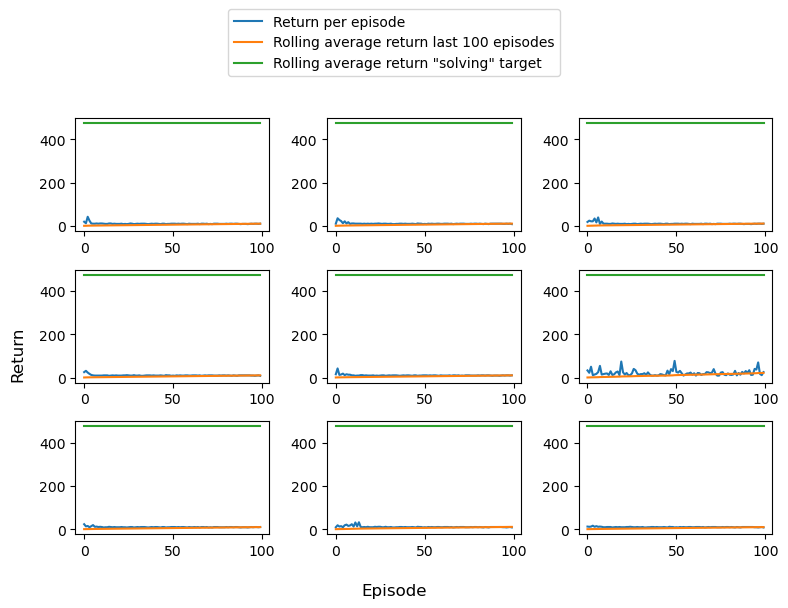

In [5]:
returns_per_run = []
env = gym.make(ENVIRONMENT_ID)
for run in range(NUM_RUNS_PER_METHOD):
    print(f"Started run {run + 1}/{NUM_RUNS_PER_METHOD}")
    policy_model = models.create_simple_nn(
        env.observation_space.shape[0],
        env.action_space.n,
        NN_HIDDEN_LAYER_SIZES,
        output_activation="softmax",
        output_dim=0
    ).to(device)
    value_model = models.create_simple_nn(env.observation_space.shape[0], 1, NN_HIDDEN_LAYER_SIZES).to(device)
    policy_optimizer = torch.optim.AdamW(policy_model.parameters(), lr=0.01)
    value_optimizer = torch.optim.AdamW(value_model.parameters(), lr=0.01)
    returns = train_episodic_one_step_actor_critic(
        env, policy_model, value_model, policy_optimizer, value_optimizer, device,
        RNG_SEED, NUM_EPISODES_PER_RUN, GAMMA, GRAD_CLIP_VALUE
    )
    returns_per_run.append(returns)
env.close()
utils.plot_returns_multiple_runs(returns_per_run, env.spec.reward_threshold)